# Reinforcement Learning: Grid World Problem using Deep Q Network (without a replay buffer)

## Introduction to the Problem

Imagine a grid of size n x m in which a robot has to traverse from a set start point to a set end point. However within the grid there are "holes" which the robot should avoid falling into. The aim is for the robot to learn the optimal path.

This aim can be achieved by implementing a reinforcement learning algorithm. The method chosen and contained is this notebook is a Deep Q Network built using PyTorch.

This DQN implementation does not include the use of a replay buffer

## Importing Necessary Libraries for this Project

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Creating the Environment

The environemt has been created as a class. 

Defining the enviroment in such a way is very useful when random environments are genareted in order to test the reliablity and stability of the DQN Algorithm
The random enviroment is not included in this notebook

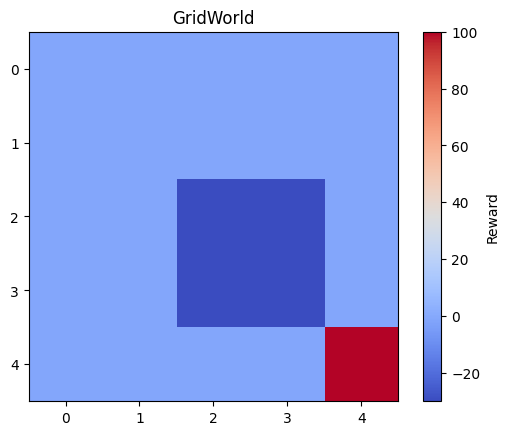

In [3]:
# Making a class for the environment
class environment:
    def __init__(self, n_x = 5, n_y = 5, initial_state = (0,0), loc_positive_reward=(4,4),
                 loc_negative_reward = [(2,2),(2,3),(3,2),(3,3)]):
        self.n_x = n_x
        self.n_y = n_y
        self.num_states = n_x * n_y
        self.initial_state = initial_state
        self.loc_positive_reward = loc_positive_reward
        self.loc_negative_reward = loc_negative_reward
        self.grid = np.zeros((self.n_y, self.n_x))
        self.rewards_field = self.map_rewards()
        
# Assigns a reward value to each state within the grid
    def assign_rewards(self,state):
        if state == self.loc_positive_reward:
            reward = 100
        elif state in self.loc_negative_reward:
            reward = -30
        else:
            reward = -1
        return reward

# Maps the assigned rewards to the grid world
    def map_rewards(self):
        rewards_field = np.zeros_like(self.grid)

        for i in range(self.n_y):
            for j in range(self.n_x):
                rewards_field[i,j] = self.assign_rewards((i,j))
        return rewards_field

    def display_rewards(self):
        print(self.rewards_field)

    def plot_rewards(self):
        plt.imshow(self.rewards_field, cmap="coolwarm", origin="upper")
        plt.colorbar(label="Reward")
        plt.title("GridWorld")
        plt.show()


env = environment()

# Ouputs a visulisation of the environment
env.plot_rewards()

## Actions

The robot has four actions it can take at each state. Up Down Left Right. However at states which lie upon a boundary the robot will be limited to only a few of these actions

It is important to define the number of total actions as this will be the number of output nodes in the neural network

In [4]:
# Define actions that agent can take
actions = {0: (-1,0), # up
           1: (1,0), # down
           2: (0,-1), # left
           3: (0,1), #right
           }

num_actions = 4

## Creating the Deep Q Network

The standard approach to creating nueral networks using PyTorch has been used.
For this project there are two hidden layers within the network.

In [5]:
# Make the neural network
class DQN(nn.Module):
    def __init__(self, in_states, h1=128, h2=128, out_actions = 4):
        super(DQN,self).__init__()
        self.fc1 = nn.Linear(in_states,h1)
        self.fc2 = nn.Linear(h1,h2)
        self.out = nn.Linear(h2, out_actions)


    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)

        return x

## Deep Q Learning Algorithm

In [6]:

class Deep_Q_Learning:
    def __init__(self,device = "cpu"):
        self.gamma = 0.9
        self.epsilon = 0.99 
        self.epsilon_decay = 0.999
        self.min_epsilon = 0.01
        self.learning_rate = 0.005
        self.network_sync_rate = 20
        self.device = torch.device(device)

# Converts coordinate states into a vector input so can be inputted into a neural network
    def state_to_vector(self, state, num_states):
        state_vector = np.zeros(num_states, dtype=np.float32)
        state_index = state[0] *env.n_x + state[1]
        state_vector[state_index] = 1
        return torch.tensor(state_vector).to(self.device)

# Training loop for Deep Q Network
    def train(self,episodes):
        self.episodes = episodes

        num_states = env.num_states

        policy_network = DQN(num_states).to(self.device)
        target_network = DQN(num_states).to(self.device)

        target_network.load_state_dict(policy_network.state_dict())
        target_network.eval()

        self.opitimiser = optim.Adam(policy_network.parameters(), lr=self.learning_rate)

        # Create empty arrays to store data for results of training
        self.store_tot_reward = np.array([])
        self.store_steps_taken = np.array([])

        for i in range(self.episodes):
            # Reset state to initial conditions
            state = env.initial_state
            total_reward = 0
            steps_taken = 0
            steps_to_sync = 0

            # Terminate each episode when the agent reaches the end goal
            while state != env.loc_positive_reward:

                state_tensor = self.state_to_vector(state, num_states).unsqueeze(0)

                if random.random() < self.epsilon:
                    action = random.choice(list(actions.keys()))
                else:
                    with torch.no_grad():
                        action = policy_network(state_tensor).argmax().item()

                move = actions[action]
                next_state = (state[0] + move[0],state[1] + move[1])

                next_state = (
                    max(0, min(env.n_y - 1, next_state[0])),
                    max(0, min(env.n_x - 1, next_state[1]))
                )

                reward = env.assign_rewards(next_state)

                total_reward += reward

                next_state_tensor = self.state_to_vector(next_state, num_states).unsqueeze(0)

                q_values = policy_network(state_tensor)
                q_value = q_values[0 , action]

                with torch.no_grad():
                    next_q_value = target_network(next_state_tensor).max()
                    target_q_value = reward + self.gamma * next_q_value

                # Mean Squared Error Loss Function
                loss = nn.MSELoss()(q_value, target_q_value)

                self.opitimiser.zero_grad()
                loss.backward()
                self.opitimiser.step()

            
                steps_taken +=  1
                steps_to_sync += 1


                if self.epsilon > self.min_epsilon:
                    self.epsilon *= self.epsilon_decay
                

                
                if steps_to_sync > self.network_sync_rate:
                    target_network.load_state_dict(policy_network.state_dict())
                    steps_to_sync = 0

                state = next_state

            self.store_tot_reward = np.append(self.store_tot_reward,total_reward) 
            self.store_steps_taken = np.append(self.store_steps_taken,steps_taken)





agent = Deep_Q_Learning()

# Train the agent with a specified number of episodes
agent.train(300)

## Visulisation of Results

The two graphs below show the total reward and steps taken plotted against the number of trials.


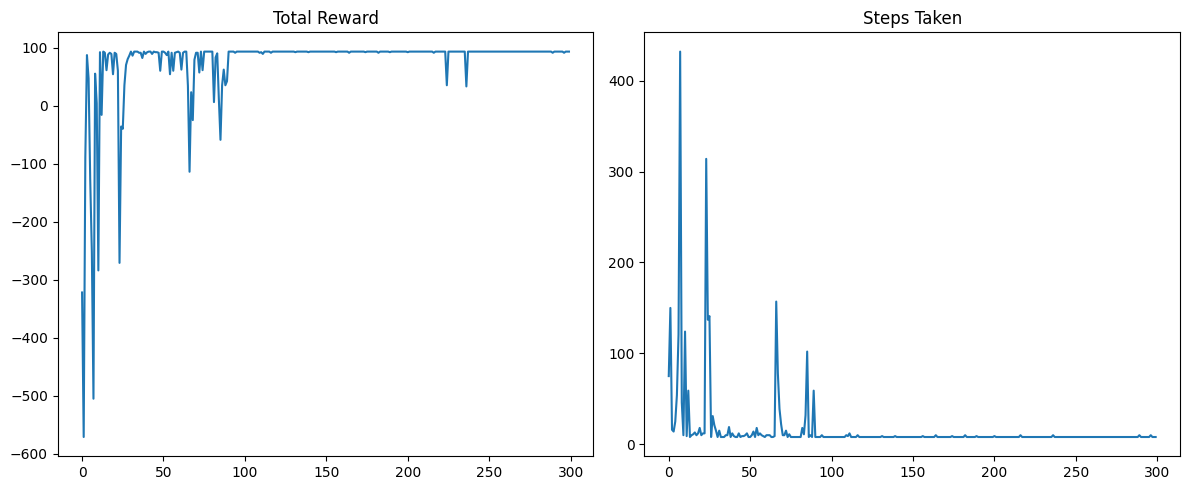

In [7]:
# Plot and display reults                

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot of total reward against the number of trials
ax1.plot(agent.store_tot_reward)
ax1.set_title('Total Reward')

# Plot of steps taken against the number of trials
ax2.plot(agent.store_steps_taken)
ax2.set_title('Steps Taken')

plt.tight_layout()
plt.savefig('Results_DQN_5x5.png')
plt.show()
